In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

db = pd.read_csv('datasets/bike_munich/rad_tage.csv')

# Load and clean data (assuming you already loaded db as your DataFrame)
db = db.dropna(subset=['gesamt', 'min-temp', 'max-temp', 'niederschlag', 'sonnenstunden'])

# Convert date to datetime
db['datum'] = pd.to_datetime(db['datum'], format='%Y.%m.%d')

# Feature engineering: Day of week and month
db['wochentag'] = db['datum'].dt.dayofweek  # 0 = Monday
db['monat'] = db['datum'].dt.month

# One-hot encode measuring stations
db = pd.get_dummies(db, columns=['zaehlstelle'], drop_first=True)

# Define features and target
feature_cols = ['min-temp', 'max-temp', 'niederschlag', 'sonnenstunden', 'wochentag', 'monat'] + \
               [col for col in db.columns if col.startswith('zaehlstelle_')]
X = db[feature_cols]
y = db['gesamt']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Predict for tomorrow (example values)
tomorrow = pd.DataFrame([{
    'min-temp': 8.5,
    'max-temp': 17.2,
    'niederschlag': 0.1,
    'sonnenstunden': 6.0,
    'wochentag': 2,  # Wednesday
    'monat': 4,
    **{col: 0 for col in X.columns if col.startswith('zaehlstelle_')}  # Default to one station (e.g., all zeros)
}])

# Optional: Set a station manually (e.g., zaehlstelle_Hirsch = 1)
if 'zaehlstelle_Hirsch' in tomorrow.columns:
    tomorrow['zaehlstelle_Hirsch'] = 1

# Predict
prediction = model.predict(tomorrow)
print(f"Tomorrow's Predicted Bike Traffic: {prediction}")


Mean Squared Error: 502019.0050725123
R-squared: 0.8508173929701432
Tomorrow's Predicted Bike Traffic: [1809.49]


In [3]:
# Convert 'datum' to datetime
db['datum'] = pd.to_datetime(db['datum'], format="%Y.%m.%d")

# --- DATE-BASED FEATURES ---
db['wochentag'] = db['datum'].dt.day_name()                            # e.g. 'Monday'
db['is_weekend'] = db['datum'].dt.weekday >= 5                        # True for Saturday/Sunday
db['monat'] = db['datum'].dt.month                                    # 1 to 12

# --- WEATHER-DERIVED FEATURES ---
db['temp_diff'] = db['max-temp'] - db['min-temp']                     # Temperature swing
db['sun_to_cloud_ratio'] = db['sonnenstunden'] / (db['bewoelkung'] + 1)  # Avoid division by zero
db['rain_binary'] = db['niederschlag'] > 0                            # True if it rained
db['extreme_weather_flag'] = (
    (db['min-temp'] < 0) |
    (db['max-temp'] > 30) |
    (db['niederschlag'] > 10) |
    (db['sonnenstunden'] == 0)
)                                                                     # Harsh day? Flag it

# Optional: convert Booleans to int if needed
db['is_weekend'] = db['is_weekend'].astype(int)
db['rain_binary'] = db['rain_binary'].astype(int)
db['extreme_weather_flag'] = db['extreme_weather_flag'].astype(int)

In [4]:
from sklearn.preprocessing import LabelEncoder

# --- Convert 'wochentag' to numeric ---
le = LabelEncoder()
db['wochentag_encoded'] = le.fit_transform(db['wochentag'])

# --- Prepare Features and Target ---
X = db[['min-temp', 'max-temp', 'niederschlag', 'sonnenstunden',
        'temp_diff', 'sun_to_cloud_ratio', 'rain_binary',
        'extreme_weather_flag', 'wochentag_encoded', 'is_weekend', 'monat']]
y = db['gesamt']

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train the model ---
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = model_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# --- Predict for tomorrow ---
# Pick any wochentag value from the encoder
wochentag_name = "Friday"
wochentag_encoded = le.transform([wochentag_name])[0]

# Sample input
tomorrow = pd.DataFrame([[8.5, 17.2, 0.1, 6.0, 8.7, 1.2, 1, 1, wochentag_encoded, 0, 4]],
    columns=['min-temp', 'max-temp', 'niederschlag', 'sonnenstunden',
             'temp_diff', 'sun_to_cloud_ratio', 'rain_binary',
             'extreme_weather_flag', 'wochentag_encoded', 'is_weekend', 'monat'])

prediction = model_rf.predict(tomorrow)
print(f"Tomorrow's Predicted Bike Traffic: {prediction[0]}")


Mean Squared Error: 3314224.777211559
R-squared: 0.015127539890743447
Tomorrow's Predicted Bike Traffic: 2411.5553412698414


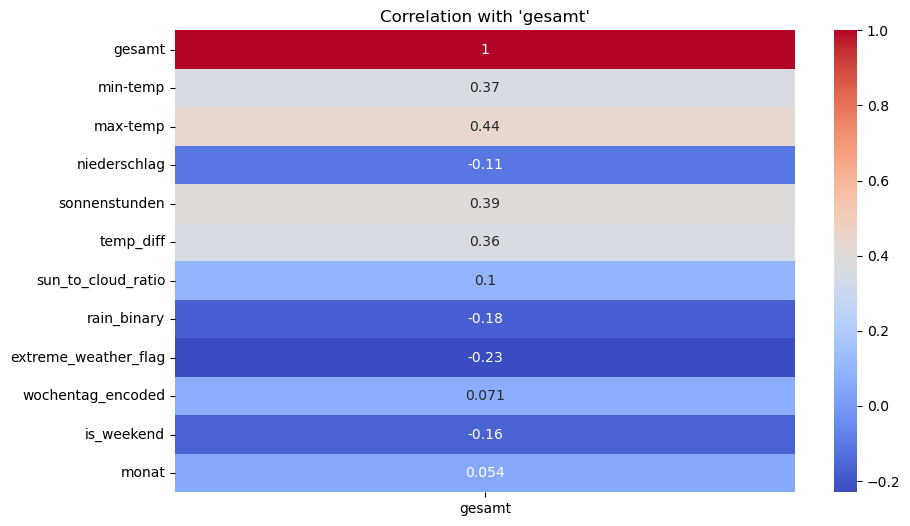

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Show correlation between all features and target
corr = db[['gesamt', 'min-temp', 'max-temp', 'niederschlag', 'sonnenstunden',
           'temp_diff', 'sun_to_cloud_ratio', 'rain_binary',
           'extreme_weather_flag', 'wochentag_encoded', 'is_weekend', 'monat']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr[['gesamt']], annot=True, cmap='coolwarm')
plt.title("Correlation with 'gesamt'")
plt.show()


In [6]:
print(corr['gesamt'].sort_values(ascending=False))

gesamt                  1.000000
max-temp                0.437552
sonnenstunden           0.394756
min-temp                0.365033
temp_diff               0.364989
sun_to_cloud_ratio      0.099568
wochentag_encoded       0.070571
monat                   0.053672
niederschlag           -0.106162
is_weekend             -0.164532
rain_binary            -0.175749
extreme_weather_flag   -0.229913
Name: gesamt, dtype: float64


In [7]:
features = [
    'max-temp',
    'sonnenstunden',
    'min-temp',
    'temp_diff',
    'wochentag_encoded',
    'rain_binary',
    'extreme_weather_flag'
]

# --- Define X and y ---
X = db[features]
y = db['gesamt']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train the Random Forest Regressor ---
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# --- Evaluate the model ---
y_pred = model_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# --- Predict tomorrow's traffic ---
tomorrow_input = pd.DataFrame([{
    'max-temp': 17.2,
    'sonnenstunden': 6.0,
    'min-temp': 8.5,
    'temp_diff': 17.2 - 8.5,
    'wochentag_encoded': 2,         # Example: Tuesday = 2 (adjust as needed)
    'rain_binary': 0,               # 0 = no rain, 1 = rain
    'extreme_weather_flag': 0       # 0 = normal, 1 = extreme
}])

prediction = model_rf.predict(tomorrow_input)
print(f"Tomorrow's Predicted Bike Traffic: {prediction[0]}")

Mean Squared Error: 3305429.0809083283
R-squared: 0.017741315249645062
Tomorrow's Predicted Bike Traffic: 1958.4811805971806


In [8]:
train_pred = model_rf.predict(X_train)
train_r2 = r2_score(y_train, train_pred)
print(f"Train R²: {train_r2}")

Train R²: 0.3613265016093239


In [9]:
db.head()

,datum,uhrzeit_start,uhrzeit_ende,richtung_1,richtung_2,gesamt,min-temp,max-temp,niederschlag,bewoelkung,...,zaehlstelle_Hirsch,zaehlstelle_Kreuther,zaehlstelle_Margareten,zaehlstelle_Olympia,is_weekend,temp_diff,sun_to_cloud_ratio,rain_binary,extreme_weather_flag,wochentag_encoded
0,2017-01-01,00:00,23:59,121.0,14.0,135.0,-6.1,2.6,0.0,36,...,False,False,False,False,1,8.7,0.159459,0,1,3
1,2017-01-01,00:00,23:59,253.0,278.0,531.0,-6.1,2.6,0.0,36,...,False,False,False,False,1,8.7,0.159459,0,1,3
2,2017-01-01,00:00,23:59,67.0,74.0,141.0,-6.1,2.6,0.0,36,...,True,False,False,False,1,8.7,0.159459,0,1,3
3,2017-01-01,00:00,23:59,14.0,16.0,30.0,-6.1,2.6,0.0,36,...,False,True,False,False,1,8.7,0.159459,0,1,3
4,2017-01-01,00:00,23:59,197.0,187.0,384.0,-6.1,2.6,0.0,36,...,False,False,True,False,1,8.7,0.159459,0,1,3


In [11]:
db.columns

Index(['datum', 'uhrzeit_start', 'uhrzeit_ende', 'richtung_1', 'richtung_2',
       'gesamt', 'min-temp', 'max-temp', 'niederschlag', 'bewoelkung',
       'sonnenstunden', 'wochentag', 'monat', 'zaehlstelle_Erhardt',
       'zaehlstelle_Hirsch', 'zaehlstelle_Kreuther', 'zaehlstelle_Margareten',
       'zaehlstelle_Olympia', 'is_weekend', 'temp_diff', 'sun_to_cloud_ratio',
       'rain_binary', 'extreme_weather_flag', 'wochentag_encoded'],
      dtype='object')